In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from dateutil import parser
import math
from scipy import stats

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set()
sns.set_style("whitegrid")

%matplotlib inline

df = pd.read_csv('dadoslimpos.csv', encoding='latin-1', sep=';', low_memory=False)

df

id Data do Atendimento Data de Nascimento Sexo Código do Procedimento Código do CID Desencadeou Internamento Data do Internamento  Idade
0        616666          2016-06-01         1920-11-12    F              301060029          Z000                      Nao                  NaN   96.0
1        200151          2016-06-01         1927-10-27    F              301010072           R42                      Nao                  NaN   89.0
2        179894          2016-06-01         1927-12-20    F              301060029          R509                      Sim  01/06/2016 14:48:00   89.0
3        179689          2016-06-01         1929-08-24    M              301060029           I10                      Nao                  NaN   87.0
4        222082          2016-06-01         1929-10-04    F              301060029          J180                      Sim  02/06/2016 09:03:00   87.0
...         ...                 ...                ...  ...                    ...           ...                      ...                  ...    ...
301910  4818769          2017-06-01         1995-03-05    F              301060096          R509                      Nao                  NaN   22.0
301911  4411991          2017-06-01         1995-09-27    M              301060029           R11                      Nao                  NaN   21.0
301912  4445685          2017-06-01         2015-09-26    F              301010072          J159                      Nao                  NaN    1.0
301913  4588803          2017-06-01         2015-10-07    M              301010072           R69                      Nao                  NaN    1.0
301914  4589860          2017-06-01         2016-06-25    M              301060096          Z539                      Nao                  NaN    1.0

[301915 rows x 9 columns]

In [2]:
def  show_series_outliers(df, x, y, scores = None, predictions = None, title = ''):
    plt.close("all")
    
    sns.set()

    fig, ax = plt.subplots(figsize=(12, 5))
    
    maxv = df[y].max()
    minv = df[y].min()
    print(minv, maxv)

    ax.set_ylim(minv - (abs(maxv-minv)/3), maxv + 0.1*maxv)

    df[y].plot(figsize=(12,6), ax=ax, lw=3)
    
#     ax = sns.lineplot(x=x, y=y, data=df, ax=ax, lw=3)

#     sns.tsplot(data = df[y], time = df[x], ax=ax, lw=3)

    if predictions:
        for row in df[df[predictions] == -1].iterrows():
            plt.axvline(x=row[0], color='k', linestyle='--', lw=2)


    if scores:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:red'
        ax2.set_ylabel('Outlier score', color=color)  # we already handled the x-label with ax1
        ax2.bar(df.index.values, df[scores].abs(), color=color, alpha=0.7)
        plt.setp(ax.patches, linewidth=0)
        ax2.tick_params(axis='y', labelcolor=color)
        
        maxv = df_analysis_a[scores].abs().max()
        q3 = df_analysis_a[scores].abs().quantile(.75)

        ax2.set_ylim(q3, maxv*2)
        ax2.grid(False)
        ax2.set_yticks([math.floor(maxv)/2, math.floor(maxv)])

        fig.tight_layout()  # otherwise the right y-label is slightly clipped


    plt.show()

In [3]:
def get_LOF_scores(df, n_neighbors=10, contamination=0.05):
    np.random.seed(42)

    # fit the model for outlier detection (default)
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    # use fit_predict to compute the predicted labels of the training samples
    # (when LOF is used for outlier detection, the estimator has no predict,
    # decision_function and score_samples methods).
    y_pred = clf.fit_predict(df)

    X_scores = clf.negative_outlier_factor_
    
    df['LOF_score'] = X_scores
    df['LOF_predictions'] = y_pred
    
    return df

def get_z_scores(df, column, z_outlier=2):
    
    df['z_score'] = np.abs(stats.zscore(df[column]))
    df['z_predictions'] = df['z_score'].apply(lambda x: -1 if x >= z_outlier else 1)
    
    return df


def get_SOM_qe_scores(df, map_size=10, contamination=0.05):
    from minisom import MiniSom

    som = MiniSom(map_size, map_size, df.shape[1], sigma=1, learning_rate=0.5,
              neighborhood_function='triangle', random_seed=10)
    
    quantization_errors = np.linalg.norm(som.quantization(df.values) - df.values, axis=1)
    
    error_treshold = np.percentile(quantization_errors, 
                               100*(1-contamination))
    
    
    df['SOM_qe_score'] = quantization_errors
    df['SOM_qe_predictions'] = df['SOM_qe_score'].apply(lambda x: -1 if x >= error_treshold else 1)
    
    return df

In [4]:
def show_2D_outliers(df, x, y, scores, title = ''):

    normalized = (df[scores].max() - df[scores]) / (df[scores].max() - df[scores].min())
    
    t = "Outlier Scores"
    if title: t=t+": "+title
    
    fig, ax = plt.subplots(figsize=(8, 6))

    plt.title(t)
    plt.scatter(x=x, y=y, color='k', s=3., label='Data points', data=df)
    # plot circles with radius proportional to the outlier scores

    plt.scatter(x=x, y=y, s=1000 * normalized, edgecolors='r',
                facecolors='none', label='Outlier scores', data=df)
    plt.axis('tight')
    # plt.xlim((-5, 5))
    # plt.ylim((-5, 5))
    # plt.xlabel("prediction errors: %d" % (n_errors))
    legend = plt.legend(loc='upper left')
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]
    plt.show()

In [5]:

#Seleciona apenas "Certain infectious and parasitic diseases (A00-B99)"
#df = df[df['Código do CID'] <= 'B99']


#Data Cleaning

#Cria faixas etárias
df['Faixa'] = np.nan
df.loc[df['Idade'] < 14, 'Faixa'] = 'Crianca'
df.loc[df['Idade'] >= 14, 'Faixa'] = 'Adulto'
df.loc[df['Idade'] >= 60, 'Faixa'] = 'Idoso'

#Converte Internamento (Sim/Nao) em binário
df['Internamento'] = 0
df.loc[df['Desencadeou Internamento'] == 'Sim', 'Internamento'] = 1

#Converte data para tipo DateTime
df['Data'] = pd.to_datetime(df['Data do Atendimento'])

#Retira códigos CID errados
df = df.loc[df.loc[:,'Código do CID'].str.contains(r'^[a-zA-Z][0-9]+$')]

#Mantém apenas o prefixo:
df['Código do CID'] = df['Código do CID'].str.slice(0, 2)

df

/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


id Data do Atendimento Data de Nascimento Sexo Código do Procedimento Código do CID Desencadeou Internamento Data do Internamento  Idade    Faixa  Internamento       Data
0        616666          2016-06-01         1920-11-12    F              301060029            Z0                      Nao                  NaN   96.0    Idoso             0 2016-06-01
1        200151          2016-06-01         1927-10-27    F              301010072            R4                      Nao                  NaN   89.0    Idoso             0 2016-06-01
2        179894          2016-06-01         1927-12-20    F              301060029            R5                      Sim  01/06/2016 14:48:00   89.0    Idoso             1 2016-06-01
3        179689          2016-06-01         1929-08-24    M              301060029            I1                      Nao                  NaN   87.0    Idoso             0 2016-06-01
4        222082          2016-06-01         1929-10-04    F              301060029            J1                      Sim  02/06/2016 09:03:00   87.0    Idoso             1 2016-06-01
...         ...                 ...                ...  ...                    ...           ...                      ...                  ...    ...      ...           ...        ...
301910  4818769          2017-06-01         1995-03-05    F              301060096            R5                      Nao                  NaN   22.0   Adulto             0 2017-06-01
301911  4411991          2017-06-01         1995-09-27    M              301060029            R1                      Nao                  NaN   21.0   Adulto             0 2017-06-01
301912  4445685          2017-06-01         2015-09-26    F              301010072            J1                      Nao                  NaN    1.0  Crianca             0 2017-06-01
301913  4588803          2017-06-01         2015-10-07    M              301010072            R6                      Nao                  NaN    1.0  Crianca             0 2017-06-01
301914  4589860          2017-06-01         2016-06-25    M              301060096            Z5                      Nao                  NaN    1.0  Crianca             0 2017-06-01

[300726 rows x 12 columns]

In [6]:
#Contagem de atendimentos por dia
df_count = df.groupby(by="Data").size().reset_index(name='Total')

df_count.head()

Data  Total
0 2016-06-01    743
1 2016-06-02    659
2 2016-06-03    688
3 2016-06-04    600
4 2016-06-05    563

/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


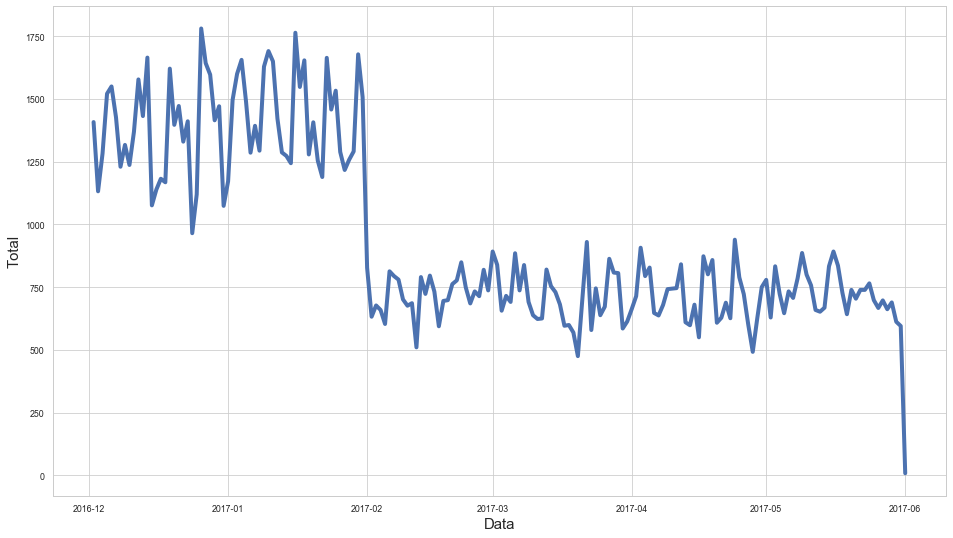

In [7]:
sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":15})   

fig, ax = plt.subplots(figsize=(16, 9))

sns.lineplot(x = 'Data', y = 'Total', ax=ax, data=df_count.query('Data > 20161201'),  lw=4)

plt.show()

### Dados inválidos

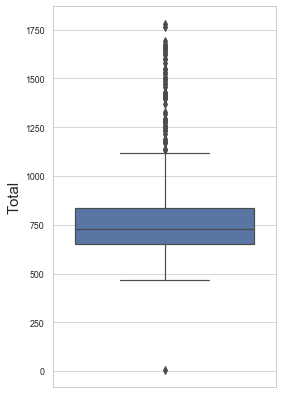

In [8]:
fig, ax = plt.subplots(figsize=(4, 7))

sns.boxplot(x=df_count["Total"], orient = 'v')

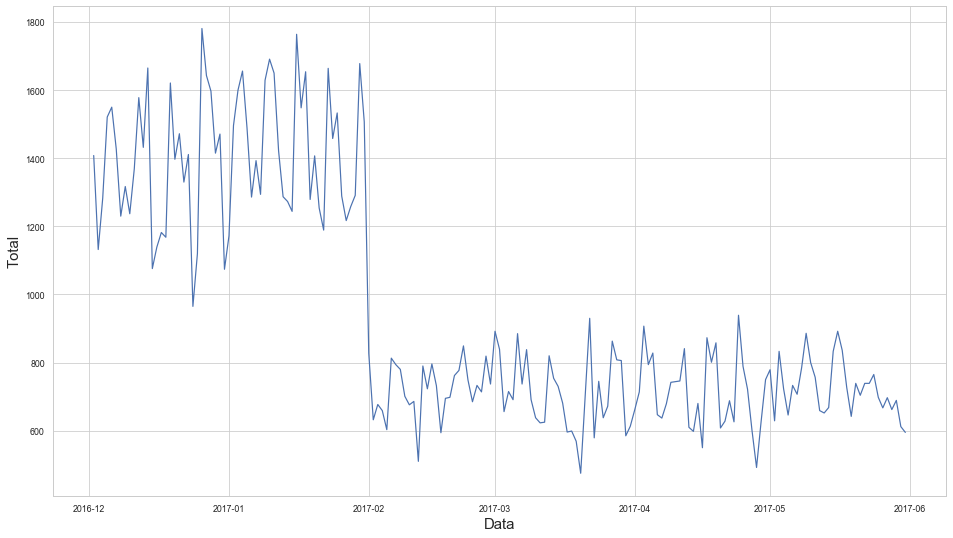

In [9]:
df_count.drop([365], inplace=True)
fig, ax = plt.subplots(figsize=(16, 9))

sns.lineplot(x = 'Data', y = 'Total', ax=ax, data=df_count.query('Data > 20161201'))

plt.show()

In [10]:
df_analysis = df_count


# #Extrai dia da semana
# df['Dia_Semana'] = df['Data'].dt.weekday

# #Extrai mês
# df['Mes'] = df['Data'].dt.month_name()

# #Extrai TimeStamp
# df['ts'] = df[['Data']].apply(lambda x: x['Data'].timestamp(), axis=1).astype(int)


df_analysis['ts'] = df_analysis[['Data']].apply(lambda x: x['Data'].timestamp(), axis=1).astype(int)

df_analysis['Dia_Semana'] = df_analysis['Data'].dt.weekday

df_analysis['Mes'] = df_analysis['Data'].dt.month_name()

df_analysis = df_analysis.query('Data > 20161201')

# df_analysis = df_analysis.set_index('Data')

df_analysis

Data  Total          ts  Dia_Semana       Mes
184 2016-12-02   1408  1480636800           4  December
185 2016-12-03   1132  1480723200           5  December
186 2016-12-04   1283  1480809600           6  December
187 2016-12-05   1521  1480896000           0  December
188 2016-12-06   1550  1480982400           1  December
189 2016-12-07   1427  1481068800           2  December
190 2016-12-08   1230  1481155200           3  December
191 2016-12-09   1317  1481241600           4  December
192 2016-12-10   1237  1481328000           5  December
193 2016-12-11   1369  1481414400           6  December
194 2016-12-12   1578  1481500800           0  December
195 2016-12-13   1432  1481587200           1  December
196 2016-12-14   1665  1481673600           2  December
197 2016-12-15   1076  1481760000           3  December
198 2016-12-16   1139  1481846400           4  December
199 2016-12-17   1182  1481932800           5  December
200 2016-12-18   1168  1482019200           6  December
201 2016-12-19   1621  1482105600           0  December
202 2016-12-20   1397  1482192000           1  December
203 2016-12-21   1472  1482278400           2  December
204 2016-12-22   1330  1482364800           3  December
205 2016-12-23   1411  1482451200           4  December
206 2016-12-24    965  1482537600           5  December
207 2016-12-25   1120  1482624000           6  December
208 2016-12-26   1781  1482710400           0  December
209 2016-12-27   1643  1482796800           1  December
210 2016-12-28   1597  1482883200           2  December
211 2016-12-29   1415  1482969600           3  December
212 2016-12-30   1471  1483056000           4  December
213 2016-12-31   1074  1483142400           5  December
214 2017-01-01   1172  1483228800           6   January
215 2017-01-02   1496  1483315200           0   January
216 2017-01-03   1600  1483401600           1   January
217 2017-01-04   1656  1483488000           2   January
218 2017-01-05   1489  1483574400           3   January
219 2017-01-06   1286  1483660800           4   January
220 2017-01-07   1393  1483747200           5   January
221 2017-01-08   1294  1483833600           6   January
222 2017-01-09   1629  1483920000           0   January
223 2017-01-10   1691  1484006400           1   January
224 2017-01-11   1650  1484092800           2   January
225 2017-01-12   1422  1484179200           3   January
226 2017-01-13   1287  1484265600           4   January
227 2017-01-14   1273  1484352000           5   January
228 2017-01-15   1244  1484438400           6   January
229 2017-01-16   1764  1484524800           0   January
230 2017-01-17   1548  1484611200           1   January
231 2017-01-18   1654  1484697600           2   January
232 2017-01-19   1279  1484784000           3   January
233 2017-01-20   1407  1484870400           4   January
234 2017-01-21   1254  1484956800           5   January
235 2017-01-22   1189  1485043200           6   January
236 2017-01-23   1664  1485129600           0   January
237 2017-01-24   1458  1485216000           1   January
238 2017-01-25   1533  1485302400           2   January
239 2017-01-26   1289  1485388800           3   January
240 2017-01-27   1217  1485475200           4   January
241 2017-01-28   1258  1485561600           5   January
242 2017-01-29   1291  1485648000           6   January
243 2017-01-30   1678  1485734400           0   January
244 2017-01-31   1507  1485820800           1   January
245 2017-02-01    827  1485907200           2  February
246 2017-02-02    632  1485993600           3  February
247 2017-02-03    677  1486080000           4  February
248 2017-02-04    659  1486166400           5  February
249 2017-02-05    603  1486252800           6  February
250 2017-02-06    813  1486339200           0  February
251 2017-02-07    794  1486425600           1  February
252 2017-02-08    780  1486512000           2  February
253 2017-02-09    701  1486598400           3  February
254 2017-02-10    676  1486684800 

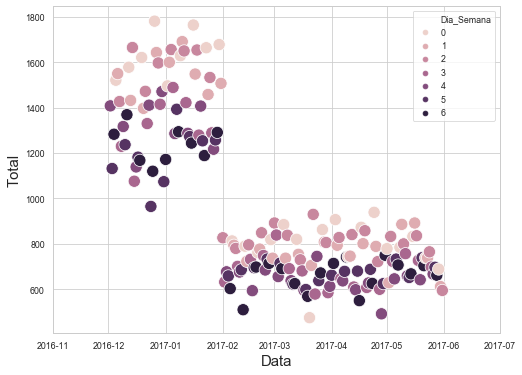

In [11]:
plt.close("all")
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x="Data", y="Total",
           hue="Dia_Semana", s=150, ax=ax, data=df_analysis.query('Data > 20161201'), legend='full')

plt.xlim(parser.parse('2016-11-01'),parser.parse('2017-07-01'))

# plt.legend(title='Dia Semana', loc='upper right', markerscale = 1, labels=['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'])


plt.show()

/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


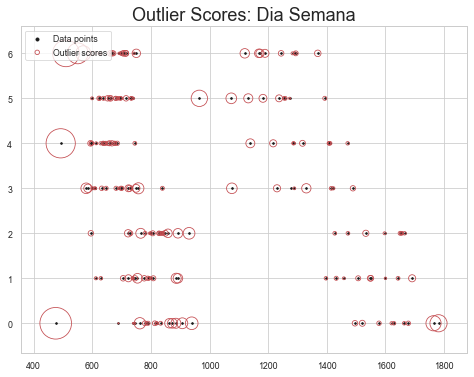

In [12]:

df_analysis_a = df_analysis[['Total', 'Dia_Semana']]

df_analysis_a = get_LOF_scores(df_analysis_a, n_neighbors=10, contamination=0.05)

show_2D_outliers(df_analysis_a, x = 'Total', y = 'Dia_Semana', scores = 'LOF_score', title = 'Dia Semana')


475 1781


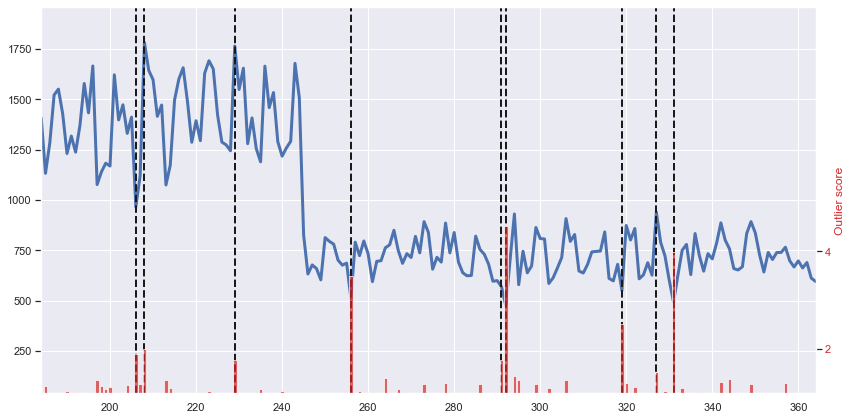

In [13]:

show_series_outliers(df_analysis_a, x = 'Dia_Semana', y = 'Total', scores = 'LOF_score', predictions = 'LOF_predictions', title = 'Dia_Semana')


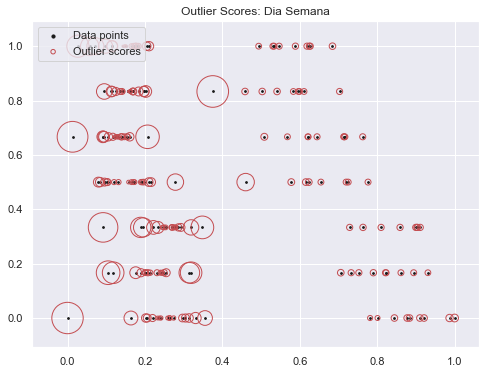

In [14]:
# normalized = normalize(df_analysis_a, axis=0)
# df_analysis_a.loc[:,:] = normalized

df_analysis_a = df_analysis[['Total', 'Dia_Semana']]

#Normaliza os dados
df_analysis_a = pd.DataFrame(
                  MinMaxScaler().fit_transform(df_analysis_a), 
                  index = df_analysis_a.index, 
                  columns=df_analysis_a.columns)

scores = get_LOF_scores(df_analysis_a, n_neighbors=10, contamination=0.3)


show_2D_outliers(df_analysis_a, x = 'Total', y = 'Dia_Semana', scores = 'LOF_score', title = 'Dia Semana')


In [15]:
# normalized = normalize(df_analysis_a, axis=0)
# df_analysis_a.loc[:,:] = normalized

#df_analysis_a = df_analysis[['Total', 'Dia_Semana']]


df_analysis_a = pd.get_dummies(df_analysis['Dia_Semana'].astype(str))
#df_m = pd.get_dummies(df_analysis['Mes'])

#df_analysis_a = pd.concat([df_s, df_m], axis=1)

df_analysis_a['Total'] = df_analysis['Total']

df_analysis_a = pd.DataFrame(MinMaxScaler().fit_transform(df_analysis_a), index = df_analysis_a.index, columns=df_analysis_a.columns)


scores = get_LOF_scores(df_analysis_a, n_neighbors=10, contamination=0.1)

df_analysis_a

0    1    2    3    4    5    6     Total  LOF_score  LOF_predictions
184  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.714395  -3.052507               -1
185  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.503063  -2.459239                1
186  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.618683  -2.401565                1
187  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.800919  -2.114867                1
188  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.823124  -1.935745                1
189  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.728943  -3.861155               -1
190  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.578101  -2.218735                1
191  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.644717  -3.007967               -1
192  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.583461  -2.517606                1
193  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.684533  -2.444722                1
194  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.844564  -2.132521                1
195  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.732772  -1.898845                1
196  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.911179  -4.137542               -1
197  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.460184  -2.380737                1
198  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.508423  -2.920846                1
199  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.541348  -2.487033                1
200  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.530628  -2.343856                1
201  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.877489  -2.145839                1
202  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.705972  -1.887901                1
203  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.763400  -3.913413               -1
204  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.654671  -2.304282                1
205  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.716692  -3.053975               -1
206  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.375191  -3.901384               -1
207  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.493874  -2.319769                1
208  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.000000  -2.195396                1
209  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.894334  -1.964827                1
210  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.859112  -4.058574               -1
211  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.719755  -2.376996                1
212  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.762634  -3.083342               -1
213  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.458652  -2.426999                1
214  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.533691  -2.345863                1
215  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.781776  -2.107123                1
216  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.861409  -1.951381                1
217  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.904288  -4.127090               -1
218  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.776417  -2.468959                1
219  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.620980  -2.992794                1
220  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.702910  -2.691038                1
221  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.627106  -2.407085                1
222  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.883614  -2.148317                1
223  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.931087  -1.979837                1
224  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.899694  -4.120122               -1
225  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.725115  -2.382984                1
226  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.621746  -2.993284               -1
227  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.611026  -2.557629                1
228  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.588821  -2.381994                1
229  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.986983  -2.190131                1
230  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.821593  -1.935120                1
231  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.902757  -4.124767               -1
232  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.615620  -2.260653                1
233  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.713629  -3.052017               -1
234  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.596478  -2.536506                1
235

In [16]:
# normalized = normalize(df_analysis_a, axis=0)
# df_analysis_a.loc[:,:] = normalized

#df_analysis_a = df_analysis[['Total', 'Dia_Semana']]


df_s = pd.get_dummies(df_analysis['Dia_Semana'].astype(str))
df_m = pd.get_dummies(df_analysis['Mes'])

df_analysis_a = pd.concat([df_s, df_m], axis=1)

df_analysis_a['Total'] = df_analysis['Total']

df_analysis_a = pd.DataFrame(MinMaxScaler().fit_transform(df_analysis_a), index = df_analysis_a.index, columns=df_analysis_a.columns)


scores = get_LOF_scores(df_analysis_a, n_neighbors=10, contamination=0.1)

df_analysis_a

0    1    2    3    4    5    6  April  December  February  January  March  May     Total  LOF_score  LOF_predictions
184  0.0  0.0  0.0  0.0  1.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.714395  -0.999902                1
185  0.0  0.0  0.0  0.0  0.0  1.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.503063  -1.000433               -1
186  0.0  0.0  0.0  0.0  0.0  0.0  1.0    0.0       1.0       0.0      0.0    0.0  0.0  0.618683  -0.999791                1
187  1.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.800919  -1.000211                1
188  0.0  1.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.823124  -0.999973                1
189  0.0  0.0  1.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.728943  -0.999930                1
190  0.0  0.0  0.0  1.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.578101  -0.999752                1
191  0.0  0.0  0.0  0.0  1.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.644717  -0.999732                1
192  0.0  0.0  0.0  0.0  0.0  1.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.583461  -1.000451               -1
193  0.0  0.0  0.0  0.0  0.0  0.0  1.0    0.0       1.0       0.0      0.0    0.0  0.0  0.684533  -0.999842                1
194  1.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.844564  -1.000302               -1
195  0.0  1.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.732772  -0.999897                1
196  0.0  0.0  1.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.911179  -0.999950                1
197  0.0  0.0  0.0  1.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.460184  -1.000481               -1
198  0.0  0.0  0.0  0.0  1.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.508423  -0.999967                1
199  0.0  0.0  0.0  0.0  0.0  1.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.541348  -1.000464               -1
200  0.0  0.0  0.0  0.0  0.0  0.0  1.0    0.0       1.0       0.0      0.0    0.0  0.0  0.530628  -0.999763                1
201  1.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.877489  -1.000309               -1
202  0.0  1.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.705972  -0.999877                1
203  0.0  0.0  1.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.763400  -1.000014                1
204  0.0  0.0  0.0  1.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.654671  -1.000024                1
205  0.0  0.0  0.0  0.0  1.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.716692  -0.999899                1
206  0.0  0.0  0.0  0.0  0.0  1.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.375191  -1.002514               -1
207  0.0  0.0  0.0  0.0  0.0  0.0  1.0    0.0       1.0       0.0      0.0    0.0  0.0  0.493874  -1.000088                1
208  1.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  1.000000  -1.001227               -1
209  0.0  1.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.894334  -0.999942                1
210  0.0  0.0  1.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.859112  -0.999975                1
211  0.0  0.0  0.0  1.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.719755  -0.999964                1
212  0.0  0.0  0.0  0.0  1.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.762634  -0.999872                1
213  0.0  0.0  0.0  0.0  0.0  1.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.458652  -1.000735               -1
214  0.0  0.0  0.0  0.0  0.0  0.0  1.0    0.0       0.0       0.0      1.0    0.0  0.0  0.533691  -1.000111                1
215  1.

0.0 1.0


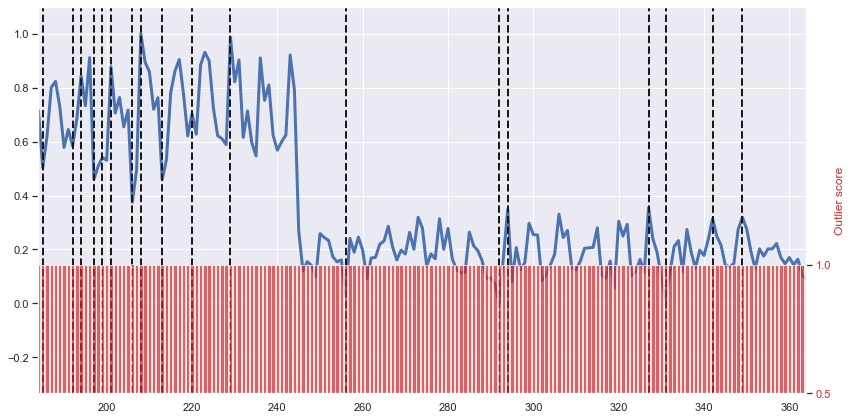

In [17]:
show_series_outliers(df_analysis_a, x = 'Dia_Semana', y = 'Total', scores = 'LOF_score', predictions = 'LOF_predictions', title = 'Dia_Semana')


/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


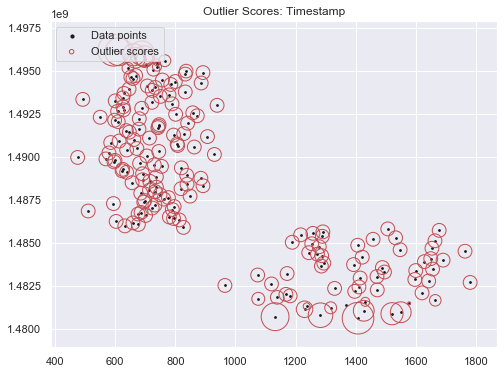

In [18]:

df_analysis_a = df_analysis[['Total', 'ts']]

scores = get_LOF_scores(df_analysis_a, n_neighbors=10, contamination=0.3)

show_2D_outliers(df_analysis_a, x = 'Total', y = 'ts', scores = 'LOF_score', title = 'Timestamp')


/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

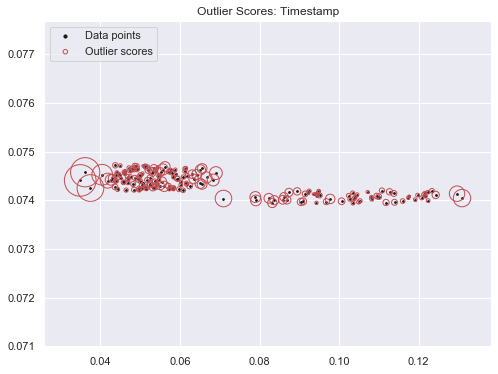

In [19]:

df_analysis_a = df_analysis[['Total', 'ts']]
normalized = normalize(df_analysis_a, axis=0)
df_analysis_a.loc[:,:] = normalized

scores = get_LOF_scores(df_analysis_a, n_neighbors=10, contamination=0.3)

show_2D_outliers(df_analysis_a, x = 'Total', y = 'ts', scores = 'LOF_score', title = 'Timestamp')



/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

0.034908133441364744 0.13088712770330654


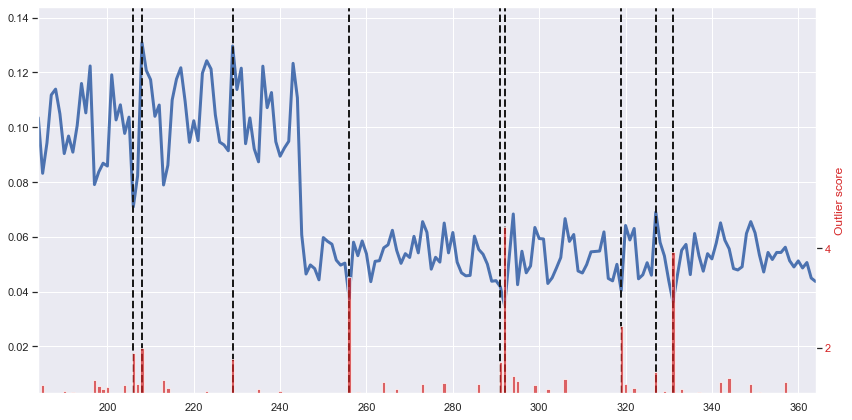

Total        ts  LOF_score  LOF_predictions
184  0.103475  0.073941  -0.986866                1
185  0.083192  0.073945  -1.239192                1
186  0.094289  0.073949  -0.973295                1
187  0.111780  0.073954  -1.071301                1
188  0.113911  0.073958  -1.058447                1
189  0.104871  0.073962  -0.990667                1
190  0.090394  0.073967  -1.124880                1
191  0.096787  0.073971  -1.068299                1
192  0.090908  0.073975  -1.115220                1
193  0.100609  0.073980  -1.094110                1
194  0.115968  0.073984  -1.012906                1
195  0.105239  0.073988  -1.001320                1
196  0.122362  0.073993  -0.985857                1
197  0.079076  0.073997  -1.343237                1
198  0.083706  0.074001  -1.229096                1
199  0.086866  0.074005  -1.166860                1
200  0.085837  0.074010  -1.206343                1
201  0.119129  0.074014  -0.980007                1
202  0.102667  0.074018  -0.986866                1
203  0.108178  0.074023  -0.991013                1
204  0.097743  0.074027  -1.253391                1
205  0.103696  0.074031  -0.991067                1
206  0.070919  0.074036  -1.897405               -1
207  0.082310  0.074040  -1.262163                1
208  0.130887  0.074044  -1.994691               -1
209  0.120745  0.074049  -0.993345                1
210  0.117365  0.074053  -0.974362                1
211  0.103989  0.074057  -0.993259                1
212  0.108105  0.074062  -0.985182                1
213  0.078929  0.074066  -1.351167                1
214  0.086131  0.074070  -1.192655                1
215  0.109942  0.074075  -1.051572                1
216  0.117585  0.074079  -0.963212                1
217  0.121701  0.074083  -0.985857                1
218  0.109428  0.074087  -1.044234                1
219  0.094509  0.074092  -0.979308                1
220  0.102373  0.074096  -1.000274                1
221  0.095097  0.074100  -1.028482                1
222  0.119717  0.074105  -0.987612                1
223  0.124273  0.074109  -1.122112                1
224  0.121260  0.074113  -0.997104                1
225  0.104504  0.074118  -0.980032                1
226  0.094583  0.074122  -0.976312                1
227  0.093554  0.074126  -0.959535                1
228  0.091423  0.074131  -1.052770                1
229  0.129638  0.074135  -1.763814               -1
230  0.113764  0.074139  -1.058447                1
231  0.121554  0.074144  -0.989594                1
232  0.093995  0.074148  -0.941423                1
233  0.103402  0.074152  -0.986866                1
234  0.092157  0.074156  -0.984424                1
235  0.087381  0.074161  -1.171745                1
236  0.122289  0.074165  -0.985857                1
237  0.107150  0.074169  -0.970551                1
238  0.112661  0.074174  -1.079776                1
239  0.094730  0.074178  -0.970272                1
240  0.089438  0.074182  -1.125699                1
241  0.092451  0.074187  -0.996024                1
242  0.094877  0.074191  -0.976318                1
243  0.123318  0.074195  -1.010333                1
244  0.110751  0.074200  -1.031628                1
245  0.060777  0.074204  -1.010077                1
246  0.046446  0.074208  -0.998310                1
247  0.049753  0.074213  -1.004790                1
248  0.048430  0.074217  -1.023017                1
249  0.044315  0.074221  -0.991851                1
250  0.059748  0.074226  -1.017847                1
251  0.058352  0.074230  -0.981186                1
252  0.057323  0.074234  -0.997161                1
253  0.051517  0.074238  -1.002635                1
254  0.049680  0.074243  -1.014999                1
255  0.050415  0.074247  -0.997128                1
256  0.037480  0.074251  -3.425104               -1
257  0.058058  0.074256  -1.003676                1
258  0.053134  0.074260  -1.096764                1
259  0.058499  0.074264  -0.969271                1
260 

In [20]:
df_analysis_a = df_analysis[['Total', 'ts']] #df_analysis.set_index('Data') #df_analysis[['Total', 'ts']]
normalized = normalize(df_analysis_a, axis=0)
df_analysis_a.loc[:,:] = normalized

df_analysis_a = get_LOF_scores(df_analysis_a, n_neighbors=10, contamination=0.05)

show_series_outliers(df_analysis_a, x = 'ts', y = 'Total', scores = 'LOF_score', predictions = 'LOF_predictions', title = 'Timestamp')

df_analysis_a


/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luizcelso/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


475 1781


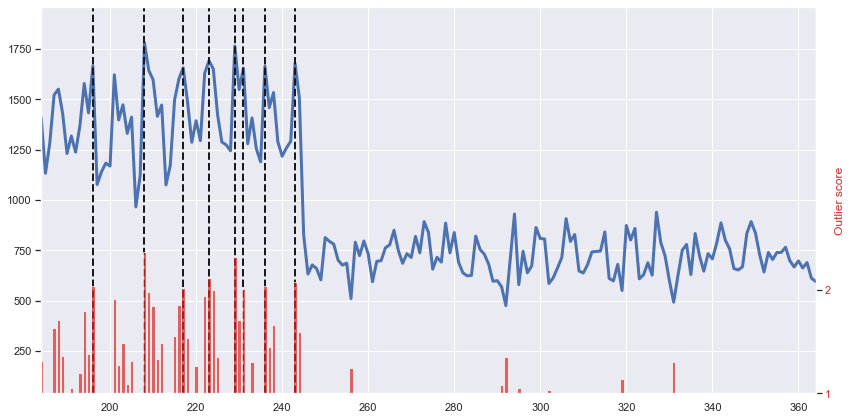

Total  Dia_Semana   z_score  z_predictions
184   1408           4  1.307973              1
185   1132           5  0.522482              1
186   1283           6  0.952225              1
187   1521           0  1.629570              1
188   1550           1  1.712103              1
189   1427           2  1.362047              1
190   1230           3  0.801388              1
191   1317           4  1.048989              1
192   1237           5  0.821310              1
193   1369           6  1.196980              1
194   1578           0  1.791791              1
195   1432           1  1.376277              1
196   1665           2  2.039391             -1
197   1076           3  0.363107              1
198   1139           4  0.542404              1
199   1182           5  0.664781              1
200   1168           6  0.624937              1
201   1621           0  1.914168              1
202   1397           1  1.276668              1
203   1472           2  1.490116              1
204   1330           3  1.085987              1
205   1411           4  1.316511              1
206    965           5  0.047202              1
207   1120           6  0.488330              1
208   1781           0  2.369525             -1
209   1643           1  1.976780              1
210   1597           2  1.845864              1
211   1415           3  1.327895              1
212   1471           4  1.487270              1
213   1074           5  0.357415              1
214   1172           6  0.636321              1
215   1496           0  1.558420              1
216   1600           1  1.854402              1
217   1656           2  2.013777             -1
218   1489           3  1.538498              1
219   1286           4  0.960763              1
220   1393           5  1.265284              1
221   1294           6  0.983531              1
222   1629           0  1.936936              1
223   1691           1  2.113387             -1
224   1650           2  1.996701              1
225   1422           3  1.347817              1
226   1287           4  0.963609              1
227   1273           5  0.923766              1
228   1244           6  0.841232              1
229   1764           0  2.321144             -1
230   1548           1  1.706411              1
231   1654           2  2.008085             -1
232   1279           3  0.940841              1
233   1407           4  1.305127              1
234   1254           5  0.869692              1
235   1189           6  0.684703              1
236   1664           0  2.036545             -1
237   1458           1  1.450273              1
238   1533           2  1.663721              1
239   1289           3  0.969301              1
240   1217           4  0.764390              1
241   1258           5  0.881076              1
242   1291           6  0.974993              1
243   1678           0  2.076389             -1
244   1507           1  1.589726              1
245    827           2  0.345543              1
246    632           3  0.900510              1
247    677           4  0.772441              1
248    659           5  0.823669              1
249    603           6  0.983044              1
250    813           0  0.385387              1
251    794           1  0.439461              1
252    780           2  0.479305              1
253    701           3  0.704137              1
254    676           4  0.775287              1
255    686           5  0.746827              1
256    510           6  1.247720              1
257    790           0  0.450845              1
258    723           1  0.641526              1
259    796           2  0.433769              1
260    732           3  0.615912              1
261    594           4  1.008658              1
262    695           5  0.721213              1
263    698           6  0.712675              1
264    762           0  0.530532              1
265    777           1  0.487843              1
266    849           

In [21]:

df_analysis_a = df_analysis[['Total', 'Dia_Semana']]

df_analysis_a = get_z_scores(df_analysis_a, 'Total')

show_series_outliers(df_analysis_a, x = 'Dia_Semana', y = 'Total', scores = 'z_score', predictions = 'z_predictions', title = 'Dia Semana')


df_analysis_a

0.0 1.0


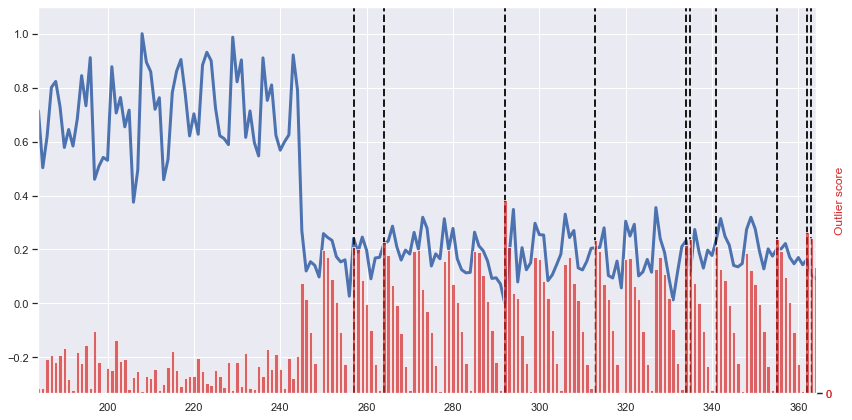

Total  Dia_Semana  SOM_qe_score  SOM_qe_predictions
184  0.714395    0.666667      0.024987                   1
185  0.503063    0.833333      0.028968                   1
186  0.618683    1.000000      0.177605                   1
187  0.800919    0.000000      0.199358                   1
188  0.823124    0.166667      0.160230                   1
189  0.728943    0.333333      0.198774                   1
190  0.578101    0.500000      0.235690                   1
191  0.644717    0.666667      0.072660                   1
192  0.583461    0.833333      0.017297                   1
193  0.684533    1.000000      0.212000                   1
194  0.844564    0.000000      0.155809                   1
195  0.732772    0.166667      0.248572                   1
196  0.911179    0.333333      0.029801                   1
197  0.460184    0.500000      0.320541                   1
198  0.508423    0.666667      0.161612                   1
199  0.541348    0.833333      0.006299                   1
200  0.530628    1.000000      0.132102                   1
201  0.877489    0.000000      0.123003                   1
202  0.705972    0.166667      0.274626                   1
203  0.763400    0.333333      0.167054                   1
204  0.654671    0.500000      0.176356                   1
205  0.716692    0.666667      0.022826                   1
206  0.375191    0.833333      0.086498                   1
207  0.493874    1.000000      0.115656                   1
208  1.000000    0.000000      0.011725                   1
209  0.894334    0.166667      0.090371                   1
210  0.859112    0.333333      0.078588                   1
211  0.719755    0.500000      0.123619                   1
212  0.762634    0.666667      0.015671                   1
213  0.458652    0.833333      0.049791                   1
214  0.533691    1.000000      0.133532                   1
215  0.781776    0.000000      0.218470                   1
216  0.861409    0.166667      0.122641                   1
217  0.904288    0.333333      0.036233                   1
218  0.776417    0.500000      0.077395                   1
219  0.620980    0.666667      0.088956                   1
220  0.702910    0.833333      0.090318                   1
221  0.627106    1.000000      0.181266                   1
222  0.883614    0.000000      0.116907                   1
223  0.931087    0.166667      0.054173                   1
224  0.899694    0.333333      0.040575                   1
225  0.725115    0.500000      0.119229                   1
226  0.621746    0.666667      0.088420                   1
227  0.611026    0.833333      0.033465                   1
228  0.588821    1.000000      0.160480                   1
229  0.986983    0.000000      0.017468                   1
230  0.821593    0.166667      0.161739                   1
231  0.902757    0.333333      0.037674                   1
232  0.615620    0.500000      0.207576                   1
233  0.713629    0.666667      0.025712                   1
234  0.596478    0.833333      0.024807                   1
235  0.546708    1.000000      0.139910                   1
236  0.910413    0.000000      0.090282                   1
237  0.752680    0.166667      0.229131                   1
238  0.810107    0.333333      0.124243                   1
239  0.623277    0.500000      0.201269                   1
240  0.568147    0.666667      0.124081                   1
241  0.599541    0.833333      0.026711                   1
242  0.624809    1.000000      0.180241                   1
243  0.921133    0.000000      0.079666                   1
244  0.790199    0.166667      0.192426                   1
245  0.269525    0.333333      0.571334                   1
246  0.120214    0.500000      0.485752                   1
247  0.154671    0.666667      0.315645                   1
248  0.140888    0.833333      0.154932                   1
249  0.098009    1.000000      0.006082         

In [22]:

df_analysis_a = df_analysis[['Total', 'Dia_Semana']]

df_analysis_a = pd.DataFrame(MinMaxScaler().fit_transform(df_analysis_a), index = df_analysis_a.index, columns=df_analysis_a.columns)

df_analysis_a = get_SOM_qe_scores(df_analysis_a, map_size=20)

show_series_outliers(df_analysis_a, x = 'Dia_Semana', y = 'Total', scores = 'SOM_qe_score', predictions = 'SOM_qe_predictions', title = 'Dia Semana')


df_analysis_a


0.0 1.0


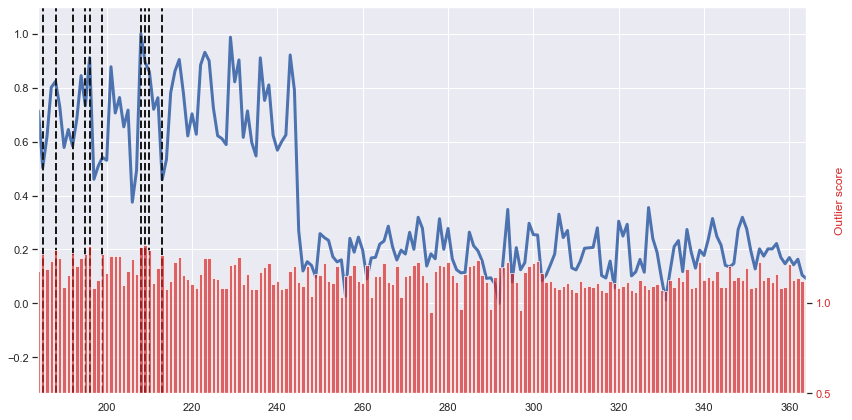

0    1    2    3    4    5    6  April  December  February  January  March  May     Total  SOM_qe_score  SOM_qe_predictions       Data
184  0.0  0.0  0.0  0.0  1.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.714395      1.173522                   1 2016-12-02
185  0.0  0.0  0.0  0.0  0.0  1.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.503063      1.265950                  -1 2016-12-03
186  0.0  0.0  0.0  0.0  0.0  0.0  1.0    0.0       1.0       0.0      0.0    0.0  0.0  0.618683      1.184865                   1 2016-12-04
187  1.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.800919      1.231455                   1 2016-12-05
188  0.0  1.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.823124      1.291563                  -1 2016-12-06
189  0.0  0.0  1.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.728943      1.247327                   1 2016-12-07
190  0.0  0.0  0.0  1.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.578101      1.087199                   1 2016-12-08
191  0.0  0.0  0.0  0.0  1.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.644717      1.153980                   1 2016-12-09
192  0.0  0.0  0.0  0.0  0.0  1.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.583461      1.275822                  -1 2016-12-10
193  0.0  0.0  0.0  0.0  0.0  0.0  1.0    0.0       1.0       0.0      0.0    0.0  0.0  0.684533      1.203921                   1 2016-12-11
194  1.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.844564      1.245805                   1 2016-12-12
195  0.0  1.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.732772      1.265553                  -1 2016-12-13
196  0.0  0.0  1.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.911179      1.313770                  -1 2016-12-14
197  0.0  0.0  0.0  1.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.460184      1.081656                   1 2016-12-15
198  0.0  0.0  0.0  0.0  1.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.508423      1.127287                   1 2016-12-16
199  0.0  0.0  0.0  0.0  0.0  1.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.541348      1.270026                  -1 2016-12-17
200  0.0  0.0  0.0  0.0  0.0  0.0  1.0    0.0       1.0       0.0      0.0    0.0  0.0  0.530628      1.164726                   1 2016-12-18
201  1.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.877489      1.257525                   1 2016-12-19
202  0.0  1.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.705972      1.258983                   1 2016-12-20
203  0.0  0.0  1.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.763400      1.258137                   1 2016-12-21
204  0.0  0.0  0.0  1.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.654671      1.097587                   1 2016-12-22
205  0.0  0.0  0.0  0.0  1.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.716692      1.174231                   1 2016-12-23
206  0.0  0.0  0.0  0.0  0.0  1.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.375191      1.239696                   1 2016-12-24
207  0.0  0.0  0.0  0.0  0.0  0.0  1.0    0.0       1.0       0.0      0.0    0.0  0.0  0.493874      1.158199                   1 2016-12-25
208  1.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  1.000000      1.307508                  -1 2016-12-26
209  0.0  1.0  0.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.894334      1.316077                  -1 2016-12-27
210  0.0  0.0  1.0  0.0  0.0  0.0  0.0    0.0       1.0       0.0      0.0    0.0  0.0  0.859112      1.292515                  -1 2016-12-28
211  0.0  0.0  0.0  1.0  0.0  0

In [23]:

df_s = pd.get_dummies(df_analysis['Dia_Semana'].astype(str))
df_m = pd.get_dummies(df_analysis['Mes'])

df_analysis_a = pd.concat([df_s, df_m], axis=1)

df_analysis_a['Total'] = df_analysis['Total']

df_analysis_a = pd.DataFrame(MinMaxScaler().fit_transform(df_analysis_a), index = df_analysis_a.index, columns=df_analysis_a.columns)

df_analysis_a = get_SOM_qe_scores(df_analysis_a, map_size=20)

df_analysis_a['Data'] = df_analysis['Data']

show_series_outliers(df_analysis_a, x = 'Data', y = 'Total', scores = 'SOM_qe_score', predictions = 'SOM_qe_predictions', title = 'Dia Semana')


df_analysis_a


In [24]:

df_mes = df_analysis[['Mes', 'Data']].set_index('Data').sample(8)

df_dummies = pd.get_dummies(df_mes)

display(df_mes)
display(df_dummies)

Mes
Data                
2016-12-21  December
2017-01-13   January
2017-05-04       May
2017-02-18  February
2017-04-26     April
2016-12-17  December
2016-12-26  December
2017-02-08  February

Mes_April  Mes_December  Mes_February  Mes_January  Mes_May
Data                                                                   
2016-12-21          0             1             0            0        0
2017-01-13          0             0             0            1        0
2017-05-04          0             0             0            0        1
2017-02-18          0             0             1            0        0
2017-04-26          1             0             0            0        0
2016-12-17          0             1             0            0        0
2016-12-26          0             1             0            0        0
2017-02-08          0             0             1            0        0

In [25]:
df_mes

Mes
Data                
2016-12-21  December
2017-01-13   January
2017-05-04       May
2017-02-18  February
2017-04-26     April
2016-12-17  December
2016-12-26  December
2017-02-08  February

In [26]:
print(df.columns)

#Seleciona apenas "Certain infectious and parasitic diseases (A00-B99)"
df_final = df[df['Código do CID'] <= 'B99']

#Contagem de atendimentos por dia e por código
df_final = df_final.groupby(['Data', 'Código do CID', 'Faixa', 'Internamento']).size().reset_index(name='Total')

df_final['Categoria'] = \
    df_final["Código do CID"] + '-' + \
    df_final["Faixa"] + '-' + \
    df_final["Internamento"].map(str)

df_final = df_final[['Data', 'Categoria', 'Total']]
df_final

Index(['id', 'Data do Atendimento', 'Data de Nascimento', 'Sexo', 'Código do Procedimento', 'Código do CID', 'Desencadeou Internamento', 'Data do Internamento', 'Idade', 'Faixa', 'Internamento', 'Data'], dtype='object')


Data     Categoria  Total
0    2016-06-01   A0-Adulto-0     18
1    2016-06-01  A0-Crianca-0     10
2    2016-06-01    A0-Idoso-0      4
3    2016-06-01   A2-Adulto-0      1
4    2016-06-01   A5-Adulto-0      1
...         ...           ...    ...
3654 2017-05-31   A5-Adulto-0      1
3655 2017-05-31  B0-Crianca-0      2
3656 2017-05-31    B0-Idoso-0      1
3657 2017-05-31  B2-Crianca-0      1
3658 2017-05-31   B8-Adulto-0      1

[3659 rows x 3 columns]

In [27]:

# Reorganiza o DataFrame para ter categorias como colunas
df_final = df_final.pivot(index='Data', columns='Categoria', values='Total').reset_index()
df_final = df_final.fillna(0)

df_final

Categoria       Data  A0-Adulto-0  A0-Adulto-1  A0-Crianca-0  A0-Crianca-1  A0-Idoso-0  A0-Idoso-1  A1-Adulto-0  A1-Adulto-1  A1-Idoso-0  A2-Adulto-0  A2-Adulto-1  A2-Crianca-0  A2-Crianca-1  A2-Idoso-0  A3-Adulto-0  A3-Crianca-0  A3-Crianca-1  A3-Idoso-0  A4-Adulto-0  A4-Adulto-1  A4-Crianca-0  A4-Crianca-1  A4-Idoso-0  A4-Idoso-1  A5-Adulto-0  A5-Idoso-0  A6-Adulto-0  A6-Crianca-0  A6-Idoso-0  A6-Idoso-1  A7-Adulto-0  A7-Idoso-0  A8-Adulto-0  A8-Adulto-1  A8-Crianca-0  A8-Crianca-1  A8-Idoso-0  A9-Adulto-0  A9-Adulto-1  A9-Crianca-0  A9-Crianca-1  A9-Idoso-0  A9-Idoso-1  B0-Adulto-0  B0-Adulto-1  B0-Crianca-0  B0-Crianca-1  B0-Idoso-0  B1-Adulto-0  B1-Adulto-1  B1-Idoso-1  B2-Adulto-0  B2-Adulto-1  B2-Crianca-0  B2-Idoso-0  B3-Adulto-0  B3-Adulto-1  B3-Crianca-0  B3-Idoso-0  B3-Idoso-1  B4-Adulto-0  B4-Crianca-0  B4-Idoso-0  B5-Adulto-0  B5-Adulto-1  B5-Idoso-0  B5-Idoso-1  B6-Adulto-0  B6-Adulto-1  B7-Crianca-0  B8-Adulto-0  B8-Adulto-1  B8-Crianca-0  B8-Idoso-0  B9-Adulto-0  \
0         2016-06-01         18.0          0.0          10.0           0.0         4.0         0.0          0.0          0.0         0.0          1.0          0.0           0.0           0.0         0.0          0.0           0.0           0.0         0.0          0.0          0.0           0.0           0.0         0.0         0.0          1.0         0.0          0.0           0.0         0.0         0.0          0.0         0.0          0.0          0.0           0.0           0.0         0.0          0.0          0.0           0.0           0.0         0.0         0.0          0.0          0.0           2.0           0.0         0.0          0.0          0.0         0.0          0.0          0.0           0.0         0.0          2.0          0.0           0.0         0.0         0.0          0.0           0.0         0.0          0.0          0.0         0.0         0.0          0.0          0.0           0.0          0.0          0.0           0.0         0.0          0.0   
1         2016-06-02         17.0          0.0           8.0           0.0         2.0         0.0          0.0          0.0         0.0          0.0          0.0           0.0           0.0         0.0          0.0           0.0           0.0         0.0          0.0          0.0           1.0           0.0         0.0         0.0          0.0         0.0          1.0           0.0         0.0         0.0          0.0         0.0          0.0          0.0           0.0           0.0         0.0          0.0          0.0           0.0           0.0         0.0         0.0          1.0          0.0           0.0           0.0         0.0          0.0          0.0         0.0          0.0          0.0           0.0         1.0          2.0          0.0           0.0         0.0         0.0          0.0           0.0         0.0          0.0          0.0         0.0         0.0          0.0          0.0           0.0          0.0          0.0           0.0         1.0          0.0   
2         2016-06-03         18.0          2.0          11.0           0.0         3.0         0.0          0.0          0.0         0.0          0.0          0.0           1.0           0.0         0.0          0.0           0.0           0.0         0.0          0.0          0.0           1.0           0.0         0.0         0.0          0.0         0.0          0.0           0.0         0.0         0.0          0.0         0.0          0.0          0.0           0.0           0.0         0.0          1.0          0.0           0.0           0.0         0.0         0.0          1.0          0.0           2.0           0.0         0.0          0.0          0.0         0.0          0.0          0.0           1.0         0.0          1.0          0.0           1.0         0.0         0.0          0.0           0.0         0.0          0.0          0.0         0.0         0.0          0.0          0.0           0.0          0.0          0.0           0.0         0.0          0.0   
3         2016-0

In [28]:

#Obtenção das dummies
df_s = pd.get_dummies(df_final['Data'].dt.day_name().astype(str))
df_m = pd.get_dummies(df_final['Data'].dt.month_name())

df_dummies = pd.concat([df_s, df_m, df_final], axis=1)

df_f =  df_dummies.drop('Data', axis=1)

#Normalização
df_f = pd.DataFrame(MinMaxScaler().fit_transform(df_f), index = df_f.index, columns=df_f.columns)


df_f

Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  April  August  December  February  January  July  June  March  May  November  October  September  A0-Adulto-0  A0-Adulto-1  A0-Crianca-0  A0-Crianca-1  A0-Idoso-0  A0-Idoso-1  A1-Adulto-0  A1-Adulto-1  A1-Idoso-0  A2-Adulto-0  A2-Adulto-1  A2-Crianca-0  A2-Crianca-1  A2-Idoso-0  A3-Adulto-0  A3-Crianca-0  A3-Crianca-1  A3-Idoso-0  A4-Adulto-0  A4-Adulto-1  A4-Crianca-0  A4-Crianca-1  A4-Idoso-0  A4-Idoso-1  A5-Adulto-0  A5-Idoso-0  A6-Adulto-0  A6-Crianca-0  A6-Idoso-0  A6-Idoso-1  A7-Adulto-0  A7-Idoso-0  A8-Adulto-0  A8-Adulto-1  A8-Crianca-0  A8-Crianca-1  A8-Idoso-0  A9-Adulto-0  A9-Adulto-1  A9-Crianca-0  A9-Crianca-1  A9-Idoso-0  A9-Idoso-1  B0-Adulto-0  B0-Adulto-1  B0-Crianca-0  B0-Crianca-1  B0-Idoso-0  B1-Adulto-0  B1-Adulto-1  B1-Idoso-1  B2-Adulto-0  B2-Adulto-1  B2-Crianca-0  B2-Idoso-0  B3-Adulto-0  B3-Adulto-1  B3-Crianca-0  B3-Idoso-0  B3-Idoso-1  B4-Adulto-0  B4-Crianca-0  B4-Idoso-0  B5-Adulto-0  \
0       0.0     0.0       0.0     0.0       0.0      0.0        1.0    0.0     0.0       0.0       0.0      0.0   0.0   1.0    0.0  0.0       0.0      0.0        0.0     0.133333          0.0      0.200000           0.0         0.4    0.000000          0.0          0.0         0.0     0.166667          0.0      0.000000           0.0         0.0          0.0          0.00           0.0         0.0         0.00         0.00           0.0           0.0       0.000    0.000000     0.166667         0.0         0.00           0.0         0.0         0.0          0.0         0.0          0.0         0.00           0.0           0.0         0.0        0.000         0.00          0.00           0.0         0.0         0.0        0.000          0.0      0.142857           0.0        0.00          0.0          0.0         0.0     0.000000          0.0          0.00         0.0     0.222222          0.0      0.000000        0.00         0.0          0.0           0.0         0.0          0.0   
1       0.0     0.0       0.0     0.0       1.0      0.0        0.0    0.0     0.0       0.0       0.0      0.0   0.0   1.0    0.0  0.0       0.0      0.0        0.0     0.122222          0.0      0.155556           0.0         0.2    0.000000          0.0          0.0         0.0     0.000000          0.0      0.000000           0.0         0.0          0.0          0.00           0.0         0.0         0.00         0.00           0.5           0.0       0.000    0.000000     0.000000         0.0         0.25           0.0         0.0         0.0          0.0         0.0          0.0         0.00           0.0           0.0         0.0        0.000         0.00          0.00           0.0         0.0         0.0        0.125          0.0      0.000000           0.0        0.00          0.0          0.0         0.0     0.000000          0.0          0.00         0.5     0.222222          0.0      0.000000        0.00         0.0          0.0           0.0         0.0          0.0   
2       1.0     0.0       0.0     0.0       0.0      0.0        0.0    0.0     0.0       0.0       0.0      0.0   0.0   1.0    0.0  0.0       0.0      0.0        0.0     0.133333          1.0      0.222222           0.0         0.3    0.000000          0.0          0.0         0.0     0.000000          0.0      0.333333           0.0         0.0          0.0          0.00           0.0         0.0         0.00         0.00           0.5           0.0       0.000    0.000000     0.000000         0.0         0.00           0.0         0.0         0.0          0.0         0.0          0.0         0.00           0.0           0.0         0.0        0.125         0.00          0.00           0.0         0.0         0.0        0.125          0.0      0.142857           0.0        0.00          0.0          0.0         0.0     0.000000          0.0          0.25         0.0     0.111111          0.0      0.083333        0.00         0.0          0.0           0.0         0.0          0.0   
3       0

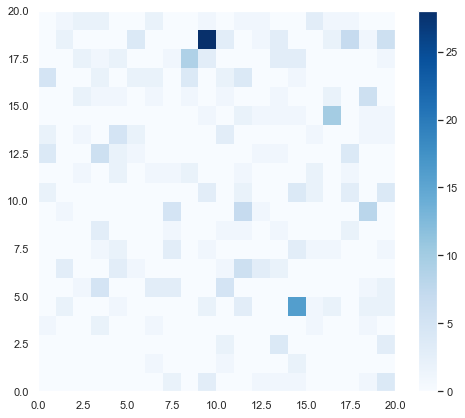

In [29]:
from minisom import MiniSom

map_size=20
contamination=0.02

som = MiniSom(map_size, map_size, df_f.shape[1], sigma=1, learning_rate=0.5,
              neighborhood_function='triangle', random_seed=10)

# Outlier scores
quantization_errors = np.linalg.norm(som.quantization(df_f.values) - df_f.values, axis=1)

# Definição de um limite para determinar um outlier
error_treshold = np.percentile(quantization_errors, 
                               100*(1-contamination))

# Exibe o mapa SOM
plt.figure(figsize=(8, 7))
frequencies = np.zeros((map_size, map_size))
for position, values in som.win_map(df_f.values).items():
    frequencies[position[0], position[1]] = len(values)
plt.pcolor(frequencies, cmap='Blues')
plt.colorbar()
plt.show()

# Armazena scores e predições no DataFrame
df_f['SOM_qe_score'] = quantization_errors
df_f['SOM_qe_predictions'] = df_f['SOM_qe_score'].apply(lambda x: -1 if x >= error_treshold else 1)

In [30]:
df_f = get_SOM_qe_scores(df_f, map_size=20, contamination=0.02)

df_f['Data'] = df_final['Data']

#show_series_outliers(df_f, x = 'Data', y = 'Total', scores = 'SOM_qe_score', predictions = 'SOM_qe_predictions', title = 'Dimensões')

df_f

Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  April  August  December  February  January  July  June  March  May  November  October  September  A0-Adulto-0  A0-Adulto-1  A0-Crianca-0  A0-Crianca-1  A0-Idoso-0  A0-Idoso-1  A1-Adulto-0  A1-Adulto-1  A1-Idoso-0  A2-Adulto-0  A2-Adulto-1  A2-Crianca-0  A2-Crianca-1  A2-Idoso-0  A3-Adulto-0  A3-Crianca-0  A3-Crianca-1  A3-Idoso-0  A4-Adulto-0  A4-Adulto-1  A4-Crianca-0  A4-Crianca-1  A4-Idoso-0  A4-Idoso-1  A5-Adulto-0  A5-Idoso-0  A6-Adulto-0  A6-Crianca-0  A6-Idoso-0  A6-Idoso-1  A7-Adulto-0  A7-Idoso-0  A8-Adulto-0  A8-Adulto-1  A8-Crianca-0  A8-Crianca-1  A8-Idoso-0  A9-Adulto-0  A9-Adulto-1  A9-Crianca-0  A9-Crianca-1  A9-Idoso-0  A9-Idoso-1  B0-Adulto-0  B0-Adulto-1  B0-Crianca-0  B0-Crianca-1  B0-Idoso-0  B1-Adulto-0  B1-Adulto-1  B1-Idoso-1  B2-Adulto-0  B2-Adulto-1  B2-Crianca-0  B2-Idoso-0  B3-Adulto-0  B3-Adulto-1  B3-Crianca-0  B3-Idoso-0  B3-Idoso-1  B4-Adulto-0  B4-Crianca-0  B4-Idoso-0  B5-Adulto-0  \
0       0.0     0.0       0.0     0.0       0.0      0.0        1.0    0.0     0.0       0.0       0.0      0.0   0.0   1.0    0.0  0.0       0.0      0.0        0.0     0.133333          0.0      0.200000           0.0         0.4    0.000000          0.0          0.0         0.0     0.166667          0.0      0.000000           0.0         0.0          0.0          0.00           0.0         0.0         0.00         0.00           0.0           0.0       0.000    0.000000     0.166667         0.0         0.00           0.0         0.0         0.0          0.0         0.0          0.0         0.00           0.0           0.0         0.0        0.000         0.00          0.00           0.0         0.0         0.0        0.000          0.0      0.142857           0.0        0.00          0.0          0.0         0.0     0.000000          0.0          0.00         0.0     0.222222          0.0      0.000000        0.00         0.0          0.0           0.0         0.0          0.0   
1       0.0     0.0       0.0     0.0       1.0      0.0        0.0    0.0     0.0       0.0       0.0      0.0   0.0   1.0    0.0  0.0       0.0      0.0        0.0     0.122222          0.0      0.155556           0.0         0.2    0.000000          0.0          0.0         0.0     0.000000          0.0      0.000000           0.0         0.0          0.0          0.00           0.0         0.0         0.00         0.00           0.5           0.0       0.000    0.000000     0.000000         0.0         0.25           0.0         0.0         0.0          0.0         0.0          0.0         0.00           0.0           0.0         0.0        0.000         0.00          0.00           0.0         0.0         0.0        0.125          0.0      0.000000           0.0        0.00          0.0          0.0         0.0     0.000000          0.0          0.00         0.5     0.222222          0.0      0.000000        0.00         0.0          0.0           0.0         0.0          0.0   
2       1.0     0.0       0.0     0.0       0.0      0.0        0.0    0.0     0.0       0.0       0.0      0.0   0.0   1.0    0.0  0.0       0.0      0.0        0.0     0.133333          1.0      0.222222           0.0         0.3    0.000000          0.0          0.0         0.0     0.000000          0.0      0.333333           0.0         0.0          0.0          0.00           0.0         0.0         0.00         0.00           0.5           0.0       0.000    0.000000     0.000000         0.0         0.00           0.0         0.0         0.0          0.0         0.0          0.0         0.00           0.0           0.0         0.0        0.125         0.00          0.00           0.0         0.0         0.0        0.125          0.0      0.142857           0.0        0.00          0.0          0.0         0.0     0.000000          0.0          0.25         0.0     0.111111          0.0      0.083333        0.00         0.0          0.0           0.0         0.0          0.0   
3       0

In [31]:
df_o = df_f[df_f['SOM_qe_predictions']==-1].sort_values('SOM_qe_score')

df_o

Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  April  August  December  February  January  July  June  March  May  November  October  September  A0-Adulto-0  A0-Adulto-1  A0-Crianca-0  A0-Crianca-1  A0-Idoso-0  A0-Idoso-1  A1-Adulto-0  A1-Adulto-1  A1-Idoso-0  A2-Adulto-0  A2-Adulto-1  A2-Crianca-0  A2-Crianca-1  A2-Idoso-0  A3-Adulto-0  A3-Crianca-0  A3-Crianca-1  A3-Idoso-0  A4-Adulto-0  A4-Adulto-1  A4-Crianca-0  A4-Crianca-1  A4-Idoso-0  A4-Idoso-1  A5-Adulto-0  A5-Idoso-0  A6-Adulto-0  A6-Crianca-0  A6-Idoso-0  A6-Idoso-1  A7-Adulto-0  A7-Idoso-0  A8-Adulto-0  A8-Adulto-1  A8-Crianca-0  A8-Crianca-1  A8-Idoso-0  A9-Adulto-0  A9-Adulto-1  A9-Crianca-0  A9-Crianca-1  A9-Idoso-0  A9-Idoso-1  B0-Adulto-0  B0-Adulto-1  B0-Crianca-0  B0-Crianca-1  B0-Idoso-0  B1-Adulto-0  B1-Adulto-1  B1-Idoso-1  B2-Adulto-0  B2-Adulto-1  B2-Crianca-0  B2-Idoso-0  B3-Adulto-0  B3-Adulto-1  B3-Crianca-0  B3-Idoso-0  B3-Idoso-1  B4-Adulto-0  B4-Crianca-0  B4-Idoso-0  B5-Adulto-0  \
208     0.0     1.0       0.0     0.0       0.0      0.0        0.0    0.0     0.0       1.0       0.0      0.0   0.0   0.0    0.0  0.0       0.0      0.0        0.0     0.822222          1.0      0.111111           0.0         0.8    0.000000          0.0          0.0         0.0          0.0          0.0      0.666667           0.0         0.0          0.0           0.0           0.0         0.0          0.0          0.0           0.0           0.0        0.25    0.000000     0.333333         1.0          0.5           0.0         0.0         0.0          0.0         0.0          0.0          0.0           0.0           0.0         0.0        0.250          0.0           0.0           0.0         0.0         0.0         0.00          0.0      0.285714           0.0         0.0          0.0          0.0         0.0     0.714286          0.0           0.0         0.0     0.666667          0.0      0.666667         0.0         0.0          0.0           0.0         0.0          0.0   
218     0.0     0.0       0.0     0.0       1.0      0.0        0.0    0.0     0.0       0.0       0.0      1.0   0.0   0.0    0.0  0.0       0.0      0.0        0.0     0.577778          0.0      0.733333           0.0         0.2    0.666667          0.0          1.0         0.0          1.0          0.0      0.000000           0.0         0.0          0.0           0.0           0.0         0.0          0.0          0.5           0.0           0.0        0.00    0.333333     0.000000         0.0          0.5           0.0         0.0         1.0          0.0         0.0          0.0          0.0           0.0           0.0         0.0        0.000          0.0           0.5           0.0         0.0         0.0         0.00          0.0      0.428571           0.0         0.5          0.0          0.0         0.0     0.571429          0.0           0.0         0.0     0.444444          0.0      0.000000         0.0         0.0          0.0           0.0         0.0          0.0   
207     0.0     0.0       0.0     1.0       0.0      0.0        0.0    0.0     0.0       1.0       0.0      0.0   0.0   0.0    0.0  0.0       0.0      0.0        0.0     0.244444          1.0      0.422222           0.0         0.4    0.666667          0.0          0.0         0.0          0.0          0.0      0.000000           0.0         0.0          0.0           0.0           0.0         0.0          0.5          0.0           1.0           0.0        0.00    0.000000     0.000000         0.0          0.0           0.0         0.0         0.0          1.0         0.0          0.0          0.0           0.0           0.0         0.0        0.000          0.0           0.0           0.0         0.0         0.0         0.25          0.0      0.571429           0.0         0.5          0.0          0.0         0.0     0.000000          0.0           0.0         1.0     0.222222          0.0      0.166667         0.5         0.0          0.0           0.0         0.0          0.0   
242     0

0.0 1.0


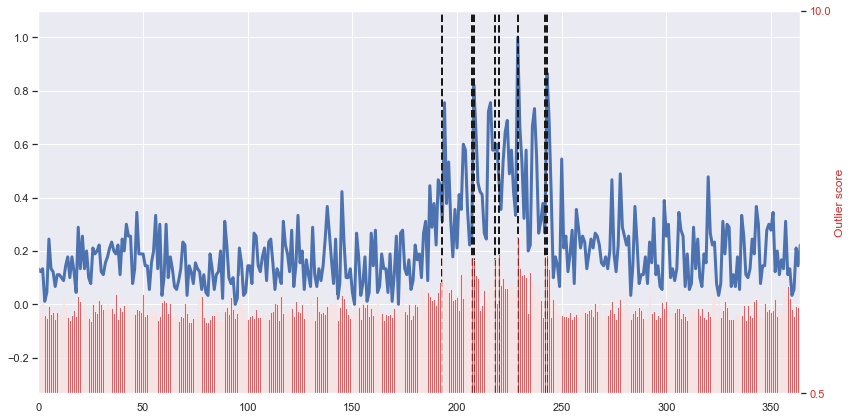

In [32]:
def  show_series_outliers2(df, x, y, scores = None, predictions = None, title = ''):
    plt.close("all")
    
    sns.set()

    fig, ax = plt.subplots(figsize=(12, 5))
    
    maxv = df[y].max()
    minv = df[y].min()
    print(minv, maxv)

    ax.set_ylim(minv - (abs(maxv-minv)/3), maxv + 0.1*maxv)

    df[y].plot(figsize=(12,6), ax=ax, lw=3)
    
#     ax = sns.lineplot(x=x, y=y, data=df, ax=ax, lw=3)

#     sns.tsplot(data = df[y], time = df[x], ax=ax, lw=3)

    if predictions:
        for row in df[df[predictions] == -1].iterrows():
            plt.axvline(x=row[0], color='k', linestyle='--', lw=2)


    if scores:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:red'
        ax2.set_ylabel('Outlier score', color=color)  # we already handled the x-label with ax1
        ax2.bar(df.index.values, df[scores].abs(), color=color, alpha=0.7)
        plt.setp(ax.patches, linewidth=0)
        ax2.tick_params(axis='y', labelcolor=color)
        
        maxv = df_analysis_a[scores].abs().max()
        q3 = df_analysis_a[scores].abs().quantile(.75)

        ax2.set_ylim(q3, maxv*2)
        ax2.grid(False)
        ax2.set_yticks([0.5, 10])

        fig.tight_layout()  # otherwise the right y-label is slightly clipped


    plt.show()


show_series_outliers2(df_f, x = 'Data', y = 'A0-Adulto-0', scores = 'SOM_qe_score', predictions = 'SOM_qe_predictions', title = 'Final')


